# Import Packages

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import time

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F

import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import sklearn.metrics as metrics

import utils
import model_zoo

# Hyper-Parameters

In [ ]:
DATASET_DIR = './data/'

BATCH_SIZE = 64
LEARNING_RATE = 0.01
EPOCHS = 10

ModelSavePath = "./Saved_model/"
if not os.path.isdir(ModelSavePath):
    os.mkdir(ModelSavePath)

USE_CUDA = torch.cuda.is_available() 
DEVICE = torch.device("cuda" if USE_CUDA else "cpu") 
print("Working with", DEVICE)

In [ ]:
TRAIN_SET, TEST_SET, train_loader, test_loader = utils.load_dataset(BATCH_SIZE=BATCH_SIZE)

In [ ]:

model_names = ['denseNet161',
               'mobilenet_v3_large',
               "mobilenet_v3_small",
               "inception",
               "resnet50",
               "resnet101",
               "resnet34"
              ]

model_lst = [model_zoo.load_model(model_name) for model_name in model_names]
criterion = nn.CrossEntropyLoss().to(DEVICE)

In [ ]:
LOSSES_TRAIN, LOSSES_VAL = [[] for idx in range(len(model_lst))], [[] for idx in range(len(model_lst))]
ACCS_VAL = [[] for idx in range(len(model_lst))]
SOTA_ACCS_VAL, SOTA_LOSS_VAL = [0 for idx in range(len(model_lst))], [0 for idx in range(len(model_lst))]
bestResult_pred_np, bestResult_anno_np = [[] for idx in range(len(model_lst))], [[] for idx in range(len(model_lst))]
bestModels = [0 for idx in range(len(model_lst))]

for model_idx, model in enumerate(model_lst):
    model.to(DEVICE)
    start = time.time()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    for epoch in tqdm(range(EPOCHS), desc="EPOCHS"):
        model.train()
        LOSS_TRACE_FOR_TRAIN, LOSS_TRACE_FOR_VAL = [], []
        for idx, batch in enumerate(train_loader):
            optimizer.zero_grad()

            X_train, Y_train = batch
            X_train, Y_train = X_train.to(DEVICE), Y_train.to(DEVICE)

            Y_pred_train = model(X_train)
            Y_train = Y_train.squeeze(-1)

            LOSS_train = criterion(Y_pred_train, Y_train)

            LOSS_TRACE_FOR_TRAIN.append(LOSS_train.cpu().detach().numpy())
            LOSS_train.backward()
            optimizer.step()        

        with torch.no_grad():
            model.eval()
            Result_pred_val, Result_anno_val = [], []
            for idx, batch in enumerate(test_loader):
                X_val, Y_val = batch
                X_val, Y_val = X_val.to(DEVICE), Y_val.to(DEVICE)

                Y_pred_val = model(X_val)
                LOSS_val = criterion(Y_pred_val, Y_val)
                LOSS_TRACE_FOR_VAL.append(LOSS_val.cpu().detach().numpy())

                Y_pred_val_np  = Y_pred_val.to('cpu').detach().numpy()
                Y_pred_val_np  = np.argmax(Y_pred_val_np, axis=1).squeeze()
                Y_val_np       = Y_val.to('cpu').detach().numpy().reshape(-1, 1).squeeze()     
                
                Result_pred_val = np.hstack((Result_pred_val, Y_pred_val_np))
                Result_anno_val = np.hstack((Result_anno_val, Y_val_np))
                # Result_pred_val.append(list(Y_pred_val_np))
                # Result_anno_val.append(list(Y_val_np))
            
            Result_pred_np = np.array(Result_pred_val)
            Result_anno_np = np.array(Result_anno_val)
            Result_pred_np = np.reshape(Result_pred_np, (-1, 1))
            Result_anno_np = np.reshape(Result_anno_np, (-1, 1))
            
            ACC_VAL        = metrics.accuracy_score(Result_anno_np, Result_pred_np)
            AVG_LOSS_TRAIN = np.average(LOSS_TRACE_FOR_TRAIN)
            AVG_LOSS_VAL   = np.average(LOSS_TRACE_FOR_VAL)

            LOSSES_TRAIN[model_idx].append(AVG_LOSS_TRAIN)
            LOSSES_VAL[model_idx].append(AVG_LOSS_VAL)
            ACCS_VAL[model_idx].append(ACC_VAL)
            
            if ACC_VAL > SOTA_ACCS_VAL[model_idx]:
                SOTA_ACCS_VAL[model_idx] = ACC_VAL
                SOTA_LOSS_VAL[model_idx] = AVG_LOSS_VAL
                bestModels[model_idx] = model
                bestResult_pred_np[model_idx] = Result_pred_np
                bestResult_anno_np[model_idx] = Result_anno_np
                
            # elif ACC_VAL == SOTA_ACCS_VAL[model_idx]:
            #     if AVG_LOSS_VAL < SOTA_LOSS_VAL[model_idx]:
            #         SOTA_ACCS_VAL[model_idx] = ACC_VAL
            #         SOTA_LOSS_VAL[model_idx] = AVG_LOSS_VAL
            #         bestModels[model_idx] = model
            #         bestResult_pred_np[model_idx] = Result_pred_np
            #         bestResult_anno_np[model_idx] = Result_anno_np
                
            print(f'(epoch {epoch + 1:03d}/{EPOCHS}) Training Loss : {AVG_LOSS_TRAIN:.5f} | Validation Loss : {AVG_LOSS_VAL:.5f} | Validation Accuracy : {ACC_VAL*100:.2f} %')
    model.to_empty()
    end = time.time()
    print(f"{model_names[model_idx]} Training took {end-start:.2f} sec")
    torch.save(bestModels[model_idx].state_dict(), ModelSavePath + model_names[model_idx] +'.pth')

In [ ]:
utils.get_metrics(models = model_lst, pred = bestResult_pred_np, anno = bestResult_anno_np)

In [9]:
import torchvision.models as models

efficientnet_b7 = models.efficientnet_b7(pretrained=True)


AttributeError: module 'torchvision.models' has no attribute 'efficientnet_b7'

In [20]:
import matplotlib.pyplot as plt
model = 'ResNet34'
string = """(epoch 001/10) Training Loss : 3.30854 | Validation Loss : 2.12802 | Validation Accuracy : 58.52 %
(epoch 002/10) Training Loss : 1.73452 | Validation Loss : 1.48807 | Validation Accuracy : 66.53 %
(epoch 003/10) Training Loss : 1.36616 | Validation Loss : 1.28020 | Validation Accuracy : 69.84 %
(epoch 004/10) Training Loss : 1.20732 | Validation Loss : 1.17803 | Validation Accuracy : 70.46 %
(epoch 005/10) Training Loss : 1.12113 | Validation Loss : 1.13783 | Validation Accuracy : 70.63 %
(epoch 006/10) Training Loss : 1.05204 | Validation Loss : 1.03972 | Validation Accuracy : 72.42 %
(epoch 007/10) Training Loss : 1.01991 | Validation Loss : 1.10224 | Validation Accuracy : 70.43 %
(epoch 008/10) Training Loss : 0.99207 | Validation Loss : 1.05563 | Validation Accuracy : 71.46 %
(epoch 009/10) Training Loss : 0.95414 | Validation Loss : 1.03860 | Validation Accuracy : 71.73 %
(epoch 010/10) Training Loss : 0.94551 | Validation Loss : 1.06044 | Validation Accuracy : 71.19 %"""
print(string)

(epoch 001/10) Training Loss : 3.30854 | Validation Loss : 2.12802 | Validation Accuracy : 58.52 %
(epoch 002/10) Training Loss : 1.73452 | Validation Loss : 1.48807 | Validation Accuracy : 66.53 %
(epoch 003/10) Training Loss : 1.36616 | Validation Loss : 1.28020 | Validation Accuracy : 69.84 %
(epoch 004/10) Training Loss : 1.20732 | Validation Loss : 1.17803 | Validation Accuracy : 70.46 %
(epoch 005/10) Training Loss : 1.12113 | Validation Loss : 1.13783 | Validation Accuracy : 70.63 %
(epoch 006/10) Training Loss : 1.05204 | Validation Loss : 1.03972 | Validation Accuracy : 72.42 %
(epoch 007/10) Training Loss : 1.01991 | Validation Loss : 1.10224 | Validation Accuracy : 70.43 %
(epoch 008/10) Training Loss : 0.99207 | Validation Loss : 1.05563 | Validation Accuracy : 71.46 %
(epoch 009/10) Training Loss : 0.95414 | Validation Loss : 1.03860 | Validation Accuracy : 71.73 %
(epoch 010/10) Training Loss : 0.94551 | Validation Loss : 1.06044 | Validation Accuracy : 71.19 %


In [18]:
train_loss = []
val_loss = []
acc = []
for s in string.split('\n'):
    count = 0
    for s_ in s.split('|'):
        if count == 0:
            train_loss.append(float(s_.split(':')[1]))
        elif count == 1:
            val_loss.append(float(s_.split(':')[1]))
        else:
            acc.append(float(s_.split(':')[1][:6]))
        count += 1
print(acc)

[58.52, 66.53, 69.84, 70.46, 70.63, 72.42, 70.43, 71.46, 71.73, 71.19]


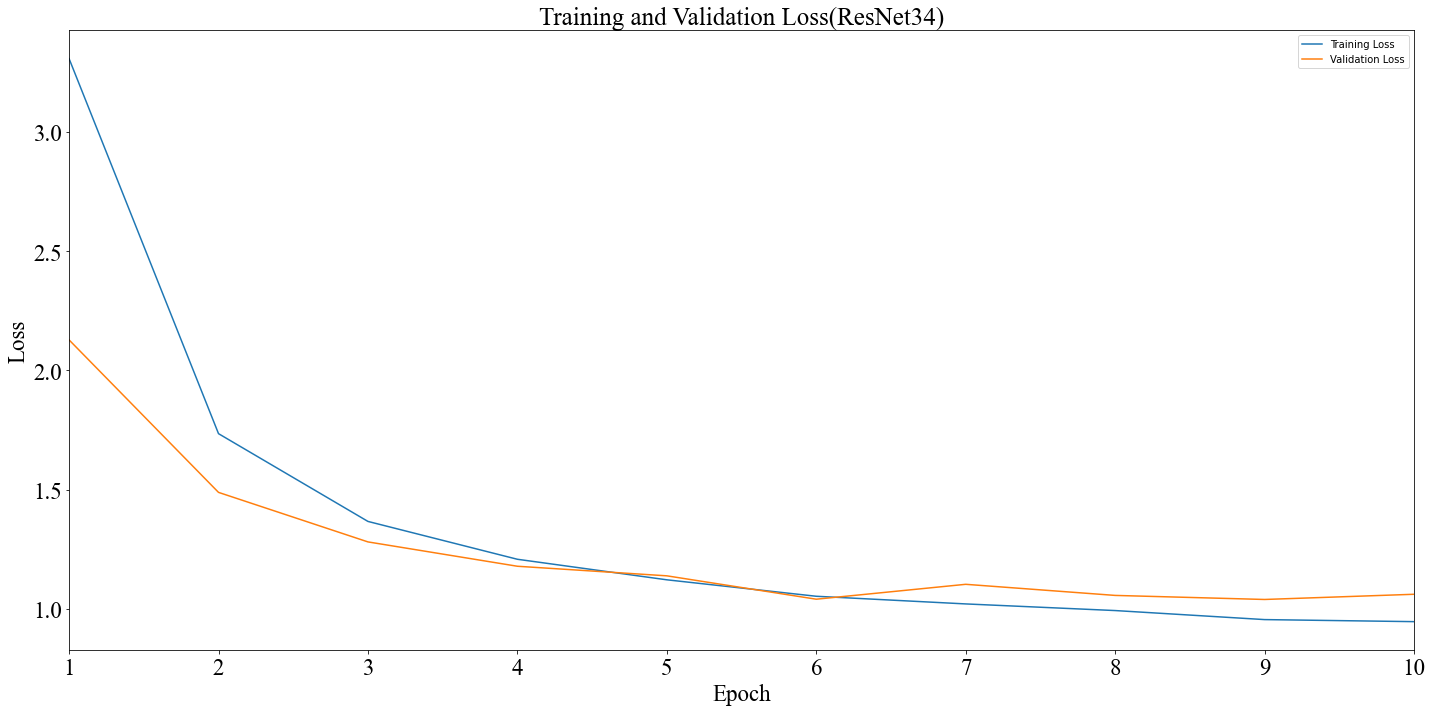

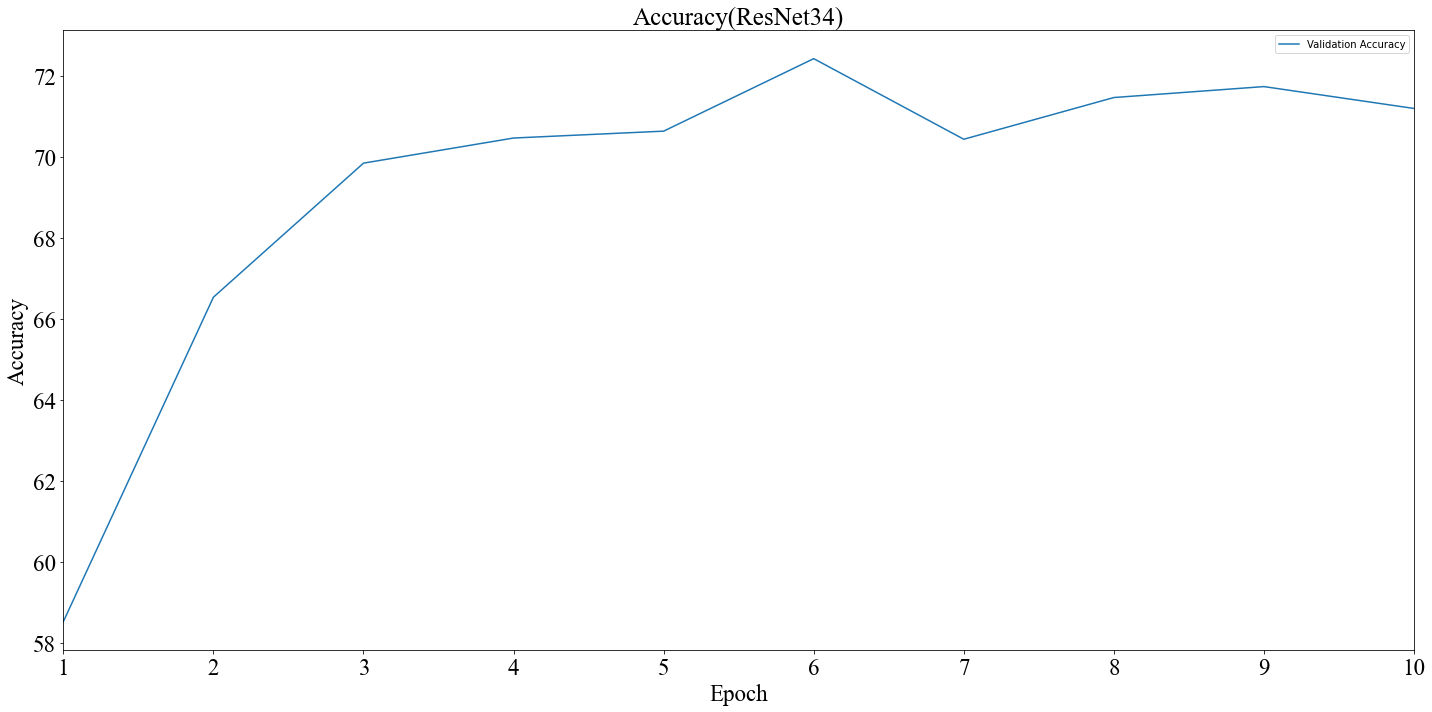

In [23]:
import matplotlib.font_manager as fm
import matplotlib as mpl
TNR = fm.FontProperties(fname='./font/times.ttf')
mpl.rcParams['axes.unicode_minus'] = False

plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["axes.titlesize"] = 20
plt.figure()
plt.title(f'Training and Validation Loss({model})', fontproperties = TNR, fontsize = 25)
plt.plot(range(1,11), train_loss, label="Training Loss")
plt.plot(range(1,11), val_loss, label="Validation Loss")
plt.xlabel('Epoch', fontproperties = TNR, fontsize=23)
plt.ylabel('Loss', fontproperties = TNR, fontsize=23)
plt.xticks(fontproperties = TNR, fontsize=23)
plt.yticks(fontproperties = TNR, fontsize=23)
plt.xlim((1,10))
plt.legend()
plt.tight_layout()
plt.show()

plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["axes.titlesize"] = 20
plt.figure()
plt.title(f'Accuracy({model})', fontproperties = TNR, fontsize = 25)
plt.plot(range(1,11), acc, label="Validation Accuracy")
plt.xlabel('Epoch', fontproperties = TNR, fontsize=23)
plt.ylabel('Accuracy', fontproperties = TNR, fontsize=23)
plt.xticks(fontproperties = TNR, fontsize=23)
plt.yticks(fontproperties = TNR, fontsize=23)
plt.xlim((1,10))
plt.legend()
plt.tight_layout()
plt.show()